# **Final Project Code**

## **Import Packages and Data** 

In [1]:
#Import Packages
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 25)

sns.set_style('whitegrid')

In [3]:
# Read in dataframes
try:
    contract_df = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/Final Project/final_provider/contract.csv', parse_dates=True)
    internet_df = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/Final Project/final_provider/internet.csv', parse_dates=True)
    personal_df = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/Final Project/final_provider/personal.csv', parse_dates=True)
    phone_df = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/Final Project/final_provider/phone.csv', parse_dates=True)
except:
    contract_df = pd.read_csv('/datasets/final_provider/contract.csv', parse_dates=True)
    internet_df = pd.read_csv('/datasets/final_provider/internet.csv', parse_dates=True)
    personal_df = pd.read_csv('/datasets/final_provider/personal.csv', parse_dates=True)
    phone_df = pd.read_csv('/datasets/final_provider/phone.csv', parse_dates=True)

In [4]:
# Print df info
print('Contract DF')
print()
print(contract_df.info())
print()

contract_df.head()

Contract DF

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [5]:
print('Internet DF')
print()
print(internet_df.info())
print()

internet_df.head()

Internet DF

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [6]:
print('Personal DF')
print() 
print(personal_df.info())
print()

personal_df.head()

Personal DF

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None



,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [7]:
print('Phone DF')
print()
print(phone_df.info())
print()

phone_df.head()

Phone DF

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None



,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


## **Prepare Data**

### Convert Column Names to Snake Case

In [8]:
# Convert column names to snake case
contract_df.columns = (contract_df.columns
                       .str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True)
                       .str.lower())

internet_df.columns = (internet_df.columns
                       .str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True)
                       .str.lower())

personal_df.columns = (personal_df.columns
                       .str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True)
                       .str.lower())

phone_df.columns = (phone_df.columns
                       .str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True)
                       .str.lower())

print('Contract Columns:')
for column in contract_df.columns:
    print(column)
print()

print('Internet Columns:')
for column in internet_df.columns:
    print(column)
print()

print('Personal Columns:')
for columnn in personal_df.columns:
    print(column)
print()

print('Phone Columns:')
for column in phone_df.columns:
    print(column)

Contract Columns:
customer_i_d
begin_date
end_date
type
paperless_billing
payment_method
monthly_charges
total_charges

Internet Columns:
customer_i_d
internet_service
online_security
online_backup
device_protection
tech_support
streaming_t_v
streaming_movies

Personal Columns:
streaming_movies
streaming_movies
streaming_movies
streaming_movies
streaming_movies

Phone Columns:
customer_i_d
multiple_lines


* All column names look good except 'customer_i_d' and 'steraming_t_v'.
* Fix these two column names below.

In [9]:
# Fix Customer ID and Streaming TV column names
contract_df.rename(columns={'customer_i_d':'customer_id'}, errors='raise', inplace=True)
internet_df.rename(columns={'customer_i_d':'customer_id', 'streaming_t_v':'streaming_tv'}, 
                   errors='raise', inplace=True)
personal_df.rename(columns={'customer_i_d':'customer_id'}, errors='raise', inplace=True)
phone_df.rename(columns={'customer_i_d':'customer_id'}, errors='raise', inplace=True)

print('Contract Columns:')
for column in contract_df.columns:
    print(column)
print()

print('Internet Columns:')
for column in internet_df.columns:
    print(column)
print()

print('Personal Columns:')
for column in personal_df.columns:
    print(column)
print()

print('Phone Columns:')
for column in phone_df.columns:
    print(column)

Contract Columns:
customer_id
begin_date
end_date
type
paperless_billing
payment_method
monthly_charges
total_charges

Internet Columns:
customer_id
internet_service
online_security
online_backup
device_protection
tech_support
streaming_tv
streaming_movies

Personal Columns:
customer_id
gender
senior_citizen
partner
dependents

Phone Columns:
customer_id
multiple_lines


* All column names are successfully converted to snake case.

### Check for Implicit Missing Values

We already know there are no np.nan missing values in the dataframes. Frequency tables of each variable are displayed to determine whether missing values have been marked with other words or symbols.

##### Contract DF Missing

In [10]:
# Categorical columns
categorical_columns = ['begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method']

for column in categorical_columns:
    display(contract_df[column].value_counts().reset_index())
    print()

,begin_date,count
0,2014-02-01,366
1,2019-10-01,237
2,2019-11-01,237
3,2019-09-01,237
4,2020-01-01,233
5,2019-12-01,220
6,2014-03-01,178
7,2019-07-01,156
8,2019-08-01,146
9,2019-06-01,141


,end_date,count
0,No,5174
1,2019-11-01 00:00:00,485
2,2019-12-01 00:00:00,466
3,2020-01-01 00:00:00,460
4,2019-10-01 00:00:00,458


,type,count
0,Month-to-month,3875
1,Two year,1695
2,One year,1473


,paperless_billing,count
0,Yes,4171
1,No,2872


,payment_method,count
0,Electronic check,2365
1,Mailed check,1612
2,Bank transfer (automatic),1544
3,Credit card (automatic),1522


* There are no implicit missing values in the contract df categorical columns.

In [11]:
# Numeric Columns
numeric_columns = ['monthly_charges', 'total_charges']

for column in numeric_columns:
    print(column)
    display(contract_df[column].value_counts().reset_index().sort_values(by=column, ascending=False).reset_index(drop=True))
    print()

monthly_charges


,monthly_charges,count
0,118.75,1
1,118.65,1
2,118.60,2
3,118.35,1
4,118.20,1
...,...,...
1580,18.75,1
1581,18.70,2
1582,18.55,1
1583,18.40,1



total_charges


,total_charges,count
0,999.9,1
1,999.8,1
2,999.45,1
3,998.1,1
4,997.75,1
...,...,...
6526,100.4,1
6527,100.35,1
6528,100.25,1
6529,100.2,1


* Total charges does have an implicit missing value marked as an empty space in the dataframe.

Fill missing value in total charges with np.nan

In [12]:
contract_df['total_charges'] = contract_df['total_charges'].replace(' ', np.nan)

display(contract_df['total_charges'].value_counts().reset_index().sort_values(by='total_charges').reset_index(drop=True))

,total_charges,count
0,100.2,1
1,100.25,1
2,100.35,1
3,100.4,1
4,100.8,1
...,...,...
6525,997.75,1
6526,998.1,1
6527,999.45,1
6528,999.8,1


In [13]:
# Check spaces have been filled with np.nan
print('Total Charges Missing:')
display(contract_df['total_charges'].isna().sum())

Total Charges Missing:


11

* Missing values have been replaced with np.nan. The number of missing values is equal to the number of spaces in the original variable.
* This is such a small number of missing values, these observations will be dropped from the analysis.

##### Internet DF Missing

In [14]:
# Check for implicit missing values
categorical_columns = ['internet_service', 'online_security', 'online_backup', 'device_protection', 
                       'tech_support', 'streaming_tv', 'streaming_movies']

for column in categorical_columns:
    display(internet_df[column].value_counts().reset_index())
    print()

,internet_service,count
0,Fiber optic,3096
1,DSL,2421


,online_security,count
0,No,3498
1,Yes,2019


,online_backup,count
0,No,3088
1,Yes,2429


,device_protection,count
0,No,3095
1,Yes,2422


,tech_support,count
0,No,3473
1,Yes,2044


,streaming_tv,count
0,No,2810
1,Yes,2707


,streaming_movies,count
0,No,2785
1,Yes,2732


* There are no implicit missing values in the internet dataframe.

##### Personal DF Missing

In [15]:
# Check for implicit missing values
categorical_columns = ['gender', 'senior_citizen', 'partner', 'dependents']

for column in categorical_columns:
    display(personal_df[column].value_counts().reset_index())

,gender,count
0,Male,3555
1,Female,3488


,senior_citizen,count
0,0,5901
1,1,1142


,partner,count
0,No,3641
1,Yes,3402


,dependents,count
0,No,4933
1,Yes,2110


* There are  no implicit missing values in the personal dataframe.

##### Phone DF Missing

In [16]:
# Check for implicit duplicates
display(phone_df['multiple_lines'].value_counts().reset_index())

,multiple_lines,count
0,No,3390
1,Yes,2971


* There are no implicit missing values in the phone dataframe.  

* All columns in all datasets have been explored for implicit missing values. 'Total_charges' is the only column with an implicit missing value; there are no implicit missing values in any other column.

### Duplicates

##### Check for full duplicates

In [17]:
print('Contract DF Duplicates:')
print(contract_df.duplicated().sum())
print()

print('Internet DF Duplicates:')
print(internet_df.duplicated().sum())
print()

print('Personal DF Duplicates:')
print(personal_df.duplicated().sum())
print()

print('Phone DF Duplicates:')
print(phone_df.duplicated().sum())

Contract DF Duplicates:
0

Internet DF Duplicates:
0

Personal DF Duplicates:
0

Phone DF Duplicates:
0


* There are no full duplicates in any dataframe.

##### Check for implicit duplicate of customer ids

In [18]:
print('Contract DF Customer ID Duplicates:')
print(contract_df['customer_id'].duplicated().sum())
print()

print('Internet DF Customer ID Duplicates:')
print(internet_df['customer_id'].duplicated().sum())
print()

print('Personal DF Customer ID Duplicates:')
print(personal_df['customer_id'].duplicated().sum())
print()

print('Phone DF Customer ID Duplicates:')
print(phone_df['customer_id'].duplicated().sum())

Contract DF Customer ID Duplicates:
0

Internet DF Customer ID Duplicates:
0

Personal DF Customer ID Duplicates:
0

Phone DF Customer ID Duplicates:
0


* There are no duplicate customer IDs in any dataframe.
* I do not have concerns about duplication in this dataset.

### Fix Data Types

The contract dataframe is the only dataframe with incorrect data types. 

##### Change begin date to datetime and total charges to float

In [19]:
print('Contract DF Original Data Types:')
print(contract_df.info())
contract_df.head()

Contract DF Original Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7032 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [20]:
# Change begin_date to datetime
contract_df['begin_date'] = pd.to_datetime(contract_df['begin_date'], yearfirst=True)

# Change total_charges to float
contract_df['total_charges'] = contract_df['total_charges'].astype('float')

print(contract_df.info())
contract_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB
None


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


* Begin date is changed to datetime. 
* Total charges is changed to float.

### Merge Data Frames

In [23]:
merged_df = contract_df.merge(personal_df, how='outer')
merged_df = merged_df.merge(internet_df, how='outer')
merged_df = merged_df.merge(phone_df, how='outer')

print(merged_df.info())
merged_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


* All dataframes have been outer-merged, and new np.nan values have been created where customers do not belong to internet or phone plans.

### Fill Missing Values from Outer Merge

Missing values from the outer merge will be filled with 'no_plan', representing customers who do not have either a phone or internet plan.

In [24]:
# Fill missing values with 'no_plan'
merged_df.iloc[: , 12:20] = merged_df.iloc[:, 12:20].fillna('no_plan')

print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

* All missing values have been filled with 'no_plan'

### Create New Features

##### Churn Feature
0 = did not churn, 1 = did churn

In [25]:
merged_df['churned'] = np.where(merged_df['end_date'] == 'No', 0, 1)

merged_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churned
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_plan,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_plan,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1


##### Begin Year Feature
Year of plan start date

In [26]:
merged_df['begin_year'] = merged_df['begin_date'].dt.year

merged_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churned,begin_year
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_plan,0,2020
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,2017
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,2019
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_plan,0,2016
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1,2019


##### Total Internet Services Feature
Sum of Internet Service Subscriptions

In [27]:
def services_sum(row):
    '''Counts the number of internet services a customer subscribes
    to and returns the total number of services.'''
    internet_services = 0
    
    security = row['online_security'] 
    backup = row['online_backup'] 
    protection = row['device_protection']
    support = row['tech_support']
    tv = row['streaming_tv']
    movies = row['streaming_movies']
    
    services = [security, backup, protection, support, tv, movies]
    
    for service in services:
        if service == 'Yes':
            internet_services += 1
            
    return internet_services

merged_df['total_internet_services'] = merged_df.apply(services_sum, axis=1)

merged_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churned,begin_year,total_internet_services
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_plan,0,2020,1
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,2017,2
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,2019,2
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_plan,0,2016,3
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1,2019,0


##### Contract Length Feature
Days from begin date to end_date, or if no end date, days from begin date to date of last update

In [28]:
# Create intermediate column with 'No' end date filled with last data update '2020-02-01'
merged_df['end_date_or_last_date'] = np.where(merged_df['end_date'] == 'No', '2020-02-01', merged_df['end_date'])

# Convert to date time
merged_df['end_date_or_last_date'] = pd.to_datetime(merged_df['end_date_or_last_date'], yearfirst=True, format='mixed')

# Create column with days between begin date and end date or 2020-02-01
merged_df['contract_length'] = (merged_df['end_date_or_last_date'] - merged_df['begin_date']).dt.days

merged_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churned,begin_year,total_internet_services,end_date_or_last_date,contract_length
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_plan,0,2020,1,2020-02-01,31
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,2017,2,2020-02-01,1036
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,2019,2,2019-12-01,61
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_plan,0,2016,3,2020-02-01,1371
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1,2019,0,2019-11-01,61


* Four new columns have been created, with churn, begin year, total internet services, and contract length (days).

### Prepare Data Conclusions
* Missing values have been explored and cleaned from the dataset. The implicit missing value in total charges of ' ' has been replaced with np.nan. There were no other missing values found.
* No duplicates were found in the four datasets.
* The four datasets have been outer-merged together. Missing values were filled with 'no_plan' to represent customers who do not have either a phone or internet service.
* Four new features were created:  
    - **churn**: 0 = did not churn, 1 = did churn
    - **begin_year**: Year of contract start date
    - **total_internet_services**: Number of internet services a customer subscribes to
    - **contract_length**: Days between plan begin date and plan end date, or if a customer has not churned, days between plan begin date and last data update (2020-01-01)

## **Exploratory Analysis**

In [29]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   customer_id              7043 non-null   object        
 1   begin_date               7043 non-null   datetime64[ns]
 2   end_date                 7043 non-null   object        
 3   type                     7043 non-null   object        
 4   paperless_billing        7043 non-null   object        
 5   payment_method           7043 non-null   object        
 6   monthly_charges          7043 non-null   float64       
 7   total_charges            7032 non-null   float64       
 8   gender                   7043 non-null   object        
 9   senior_citizen           7043 non-null   int64         
 10  partner                  7043 non-null   object        
 11  dependents               7043 non-null   object        
 12  internet_service         7043 non-

##### Bar Plots of Categorical Columns

In [43]:
categorical_columns = merged_df.drop(['customer_id', 'begin_date', 'monthly_charges', 'total_charges', 
                                      'contract_length', 'end_date_or_last_date'], axis=1)

display(categorical_columns.head())

,end_date,type,paperless_billing,payment_method,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churned,begin_year,total_internet_services
0,No,Month-to-month,Yes,Electronic check,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_plan,0,2020,1
1,No,One year,No,Mailed check,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,2017,2
2,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,2019,2
3,No,One year,No,Bank transfer (automatic),Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_plan,0,2016,3
4,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1,2019,0


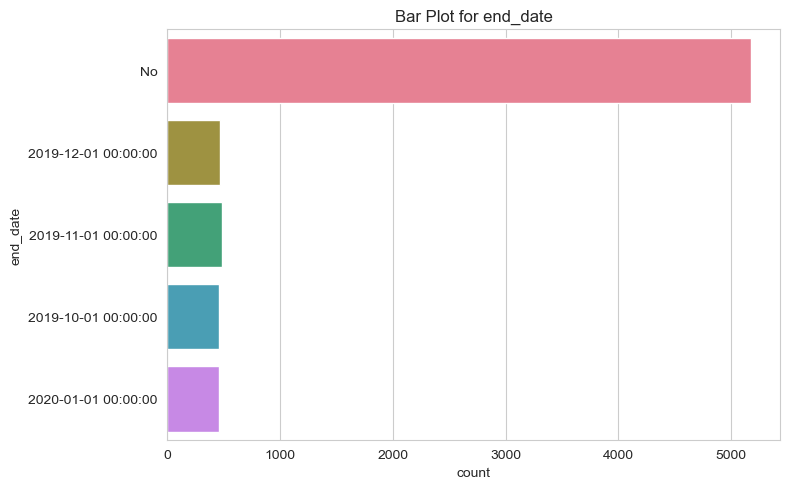

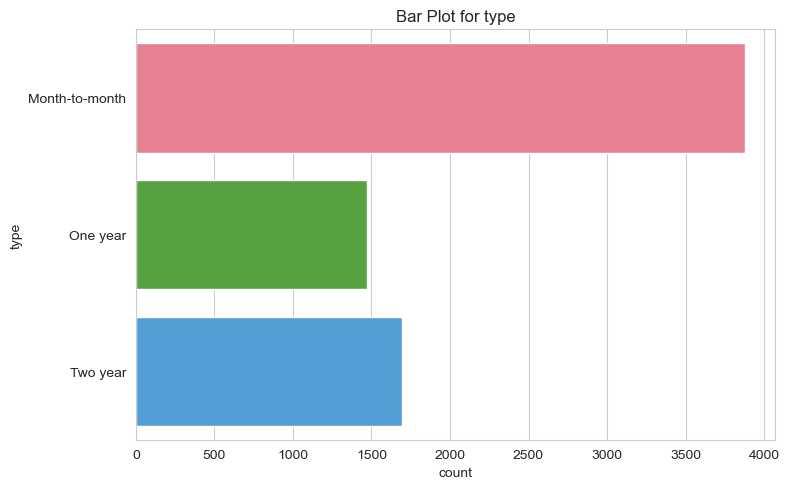

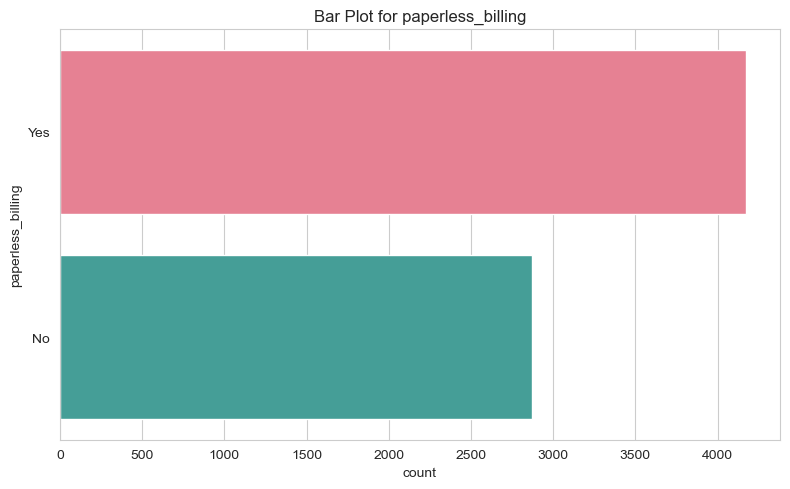

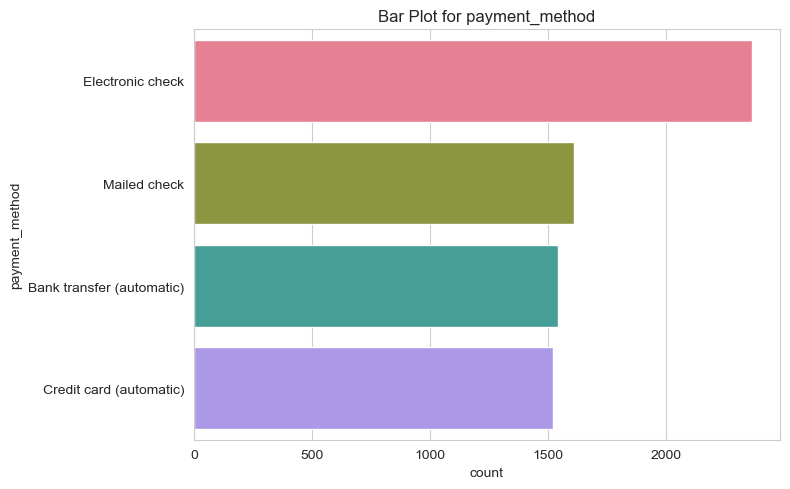

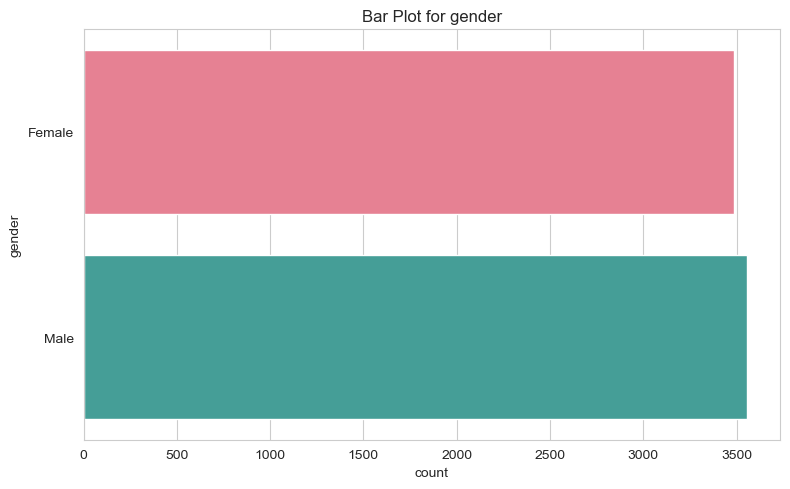

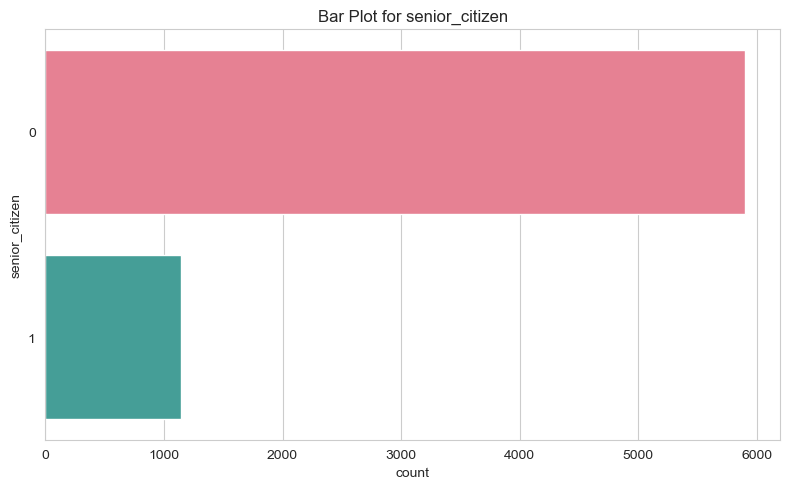

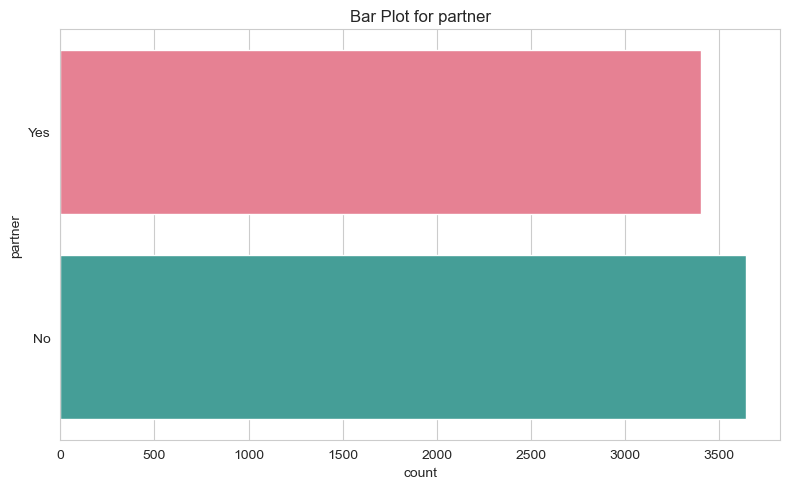

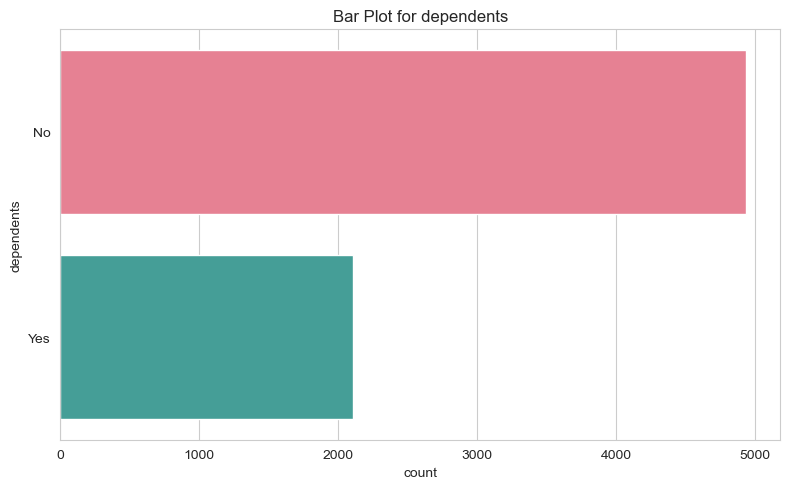

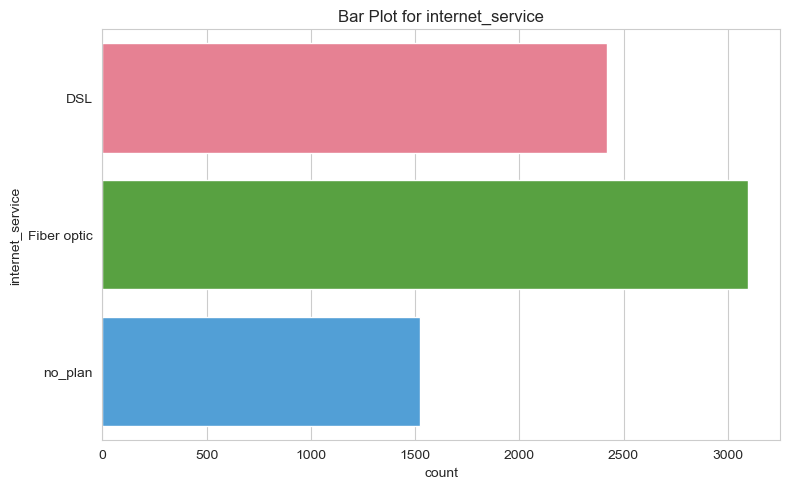

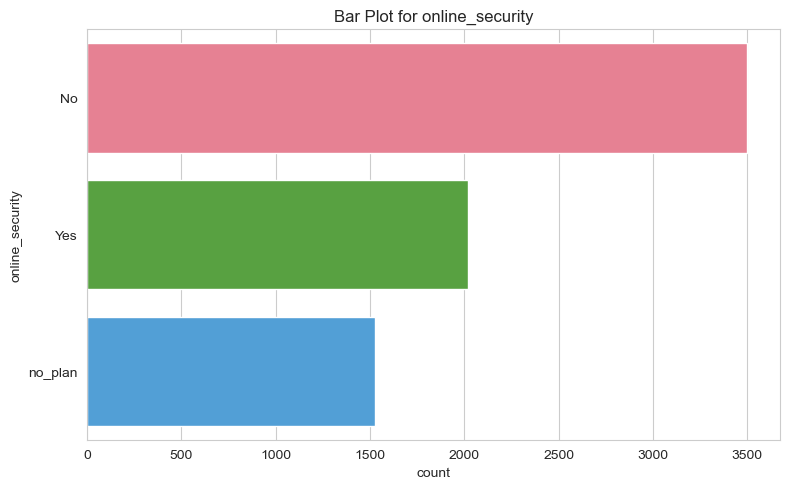

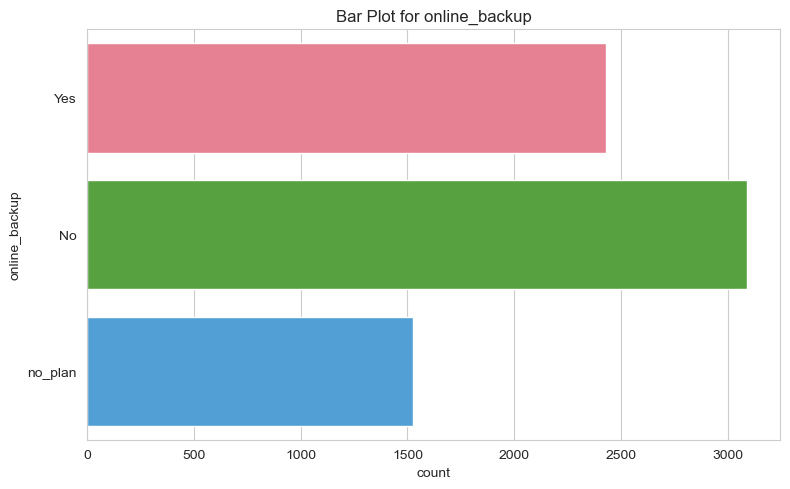

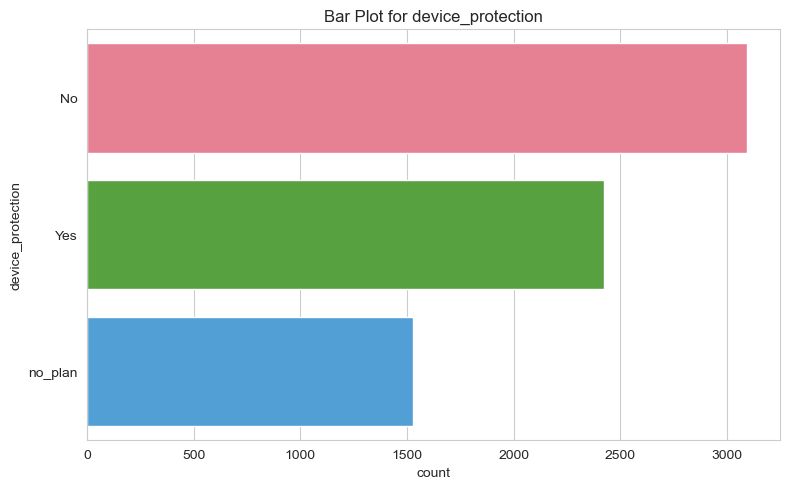

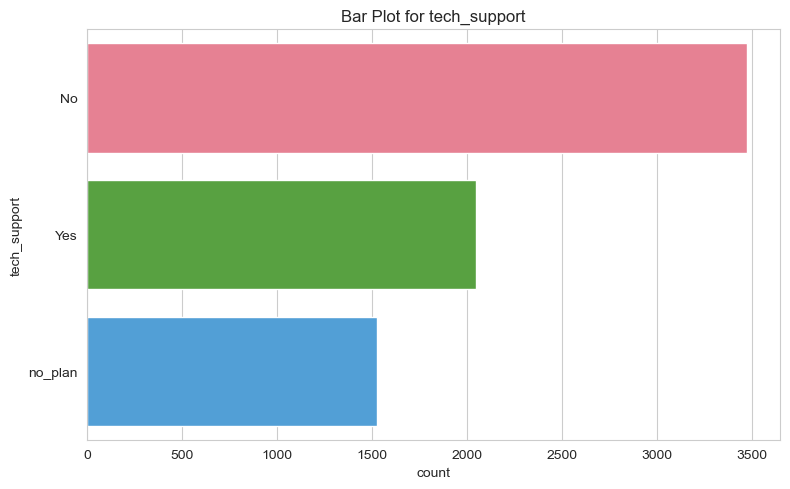

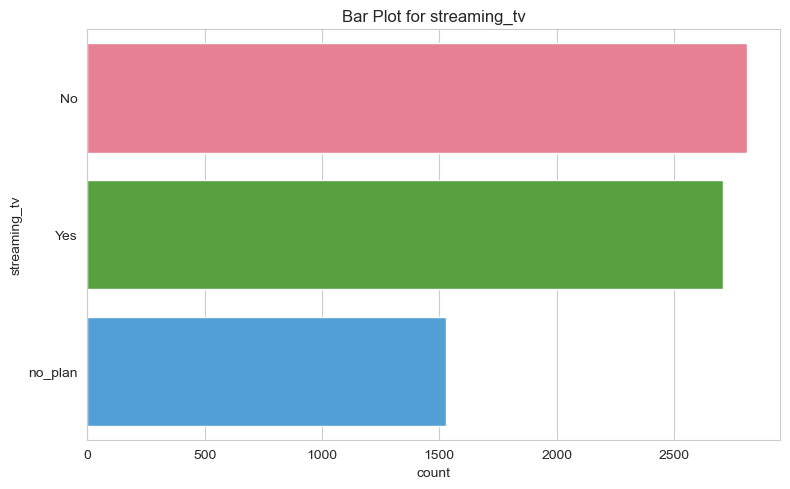

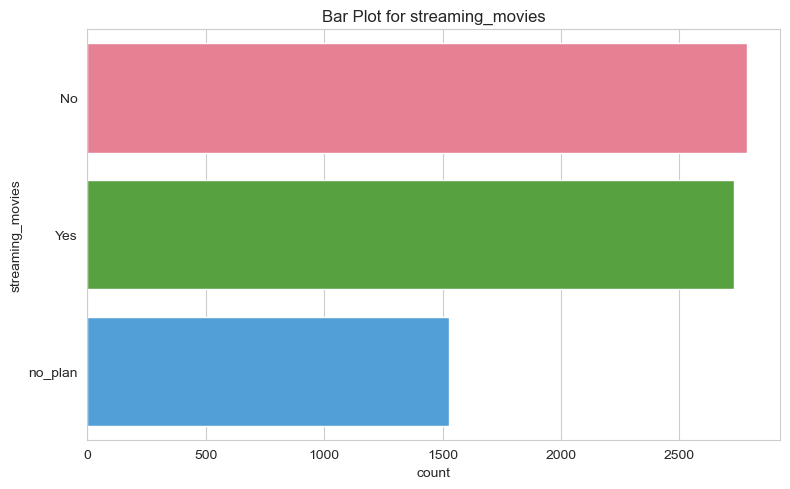

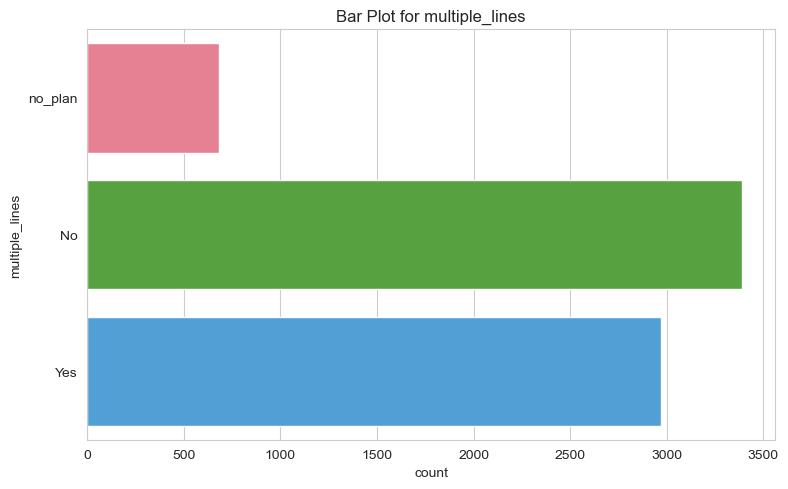

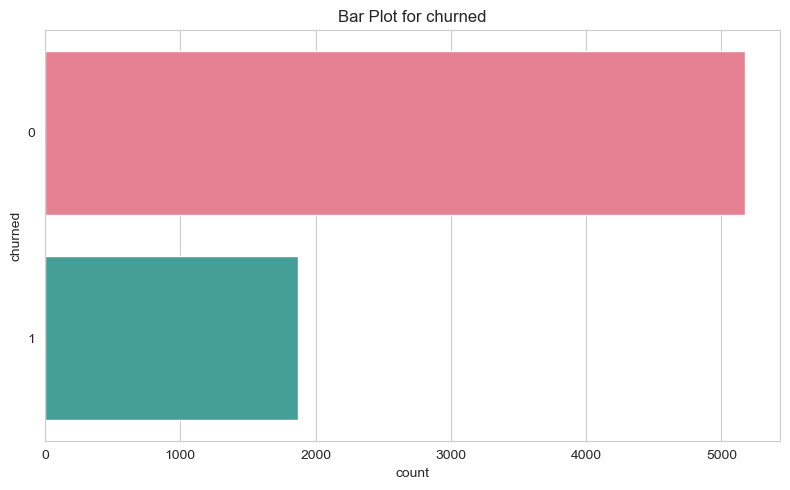

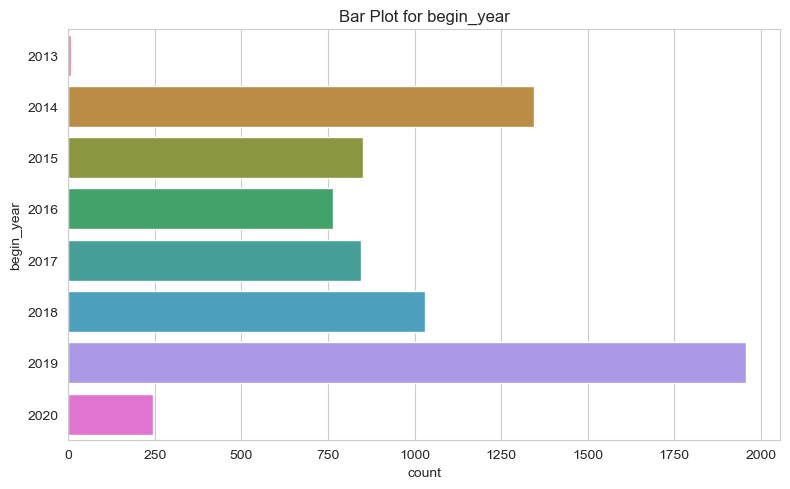

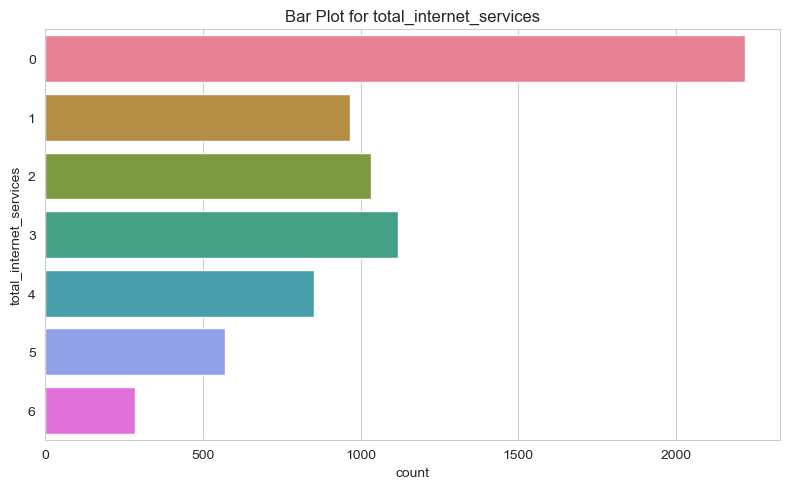

In [44]:
for column in categorical_columns.columns:
    fig, ax = plt.subplots(figsize=(8, 5))
    count_plot = sns.countplot(merged_df, y=column, palette='husl', ax=ax)
    plt.title(f'Bar Plot for {column}')
    plt.tight_layout()
    plt.show()

##### Time Series of Customer Churn by Plan Start Date

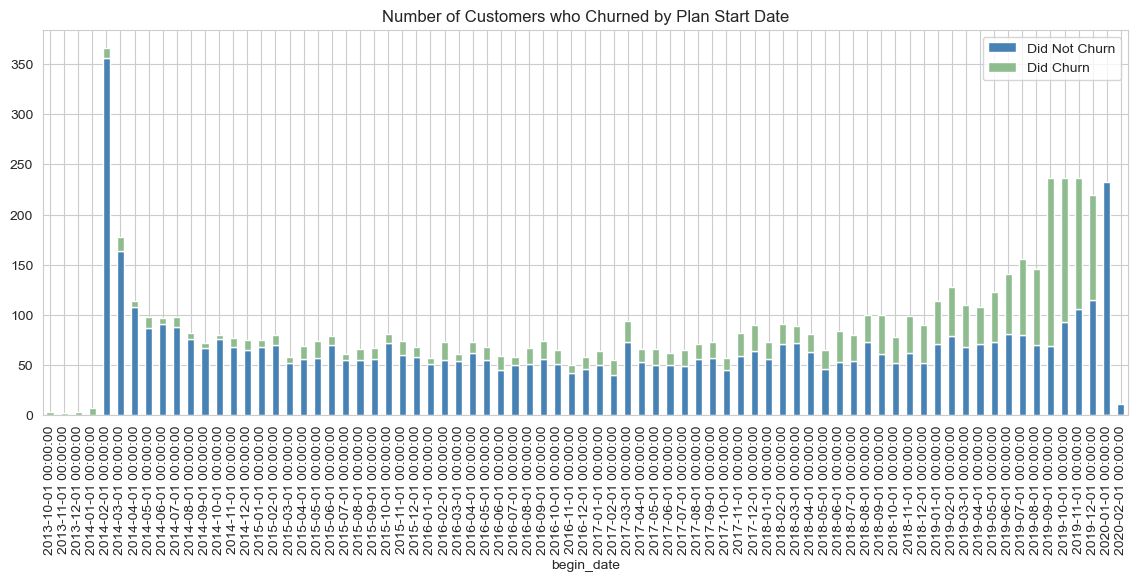

In [65]:
# Time Series plot for Begin Date Colored by Churned

churned_by_date = merged_df.groupby(['begin_date', 'churned']).size().reset_index().pivot(columns='churned', index='begin_date', values=0)

churned_by_date.plot(kind='bar', stacked=True, figsize=(14, 5), color=['steelblue', 'darkseagreen'])

plt.title('Number of Customers who Churned by Plan Start Date')
plt.legend(['Did Not Churn', 'Did Churn'])

plt.show()

* Customers who began their contracts in 2014 - 2018 are almost all still with the company.
* About 50% of customers who began their contracts in 2019 - 2020 have already churned.
* New customers are more likely to leave than old customers.

##### Histograms of Continuous Variables

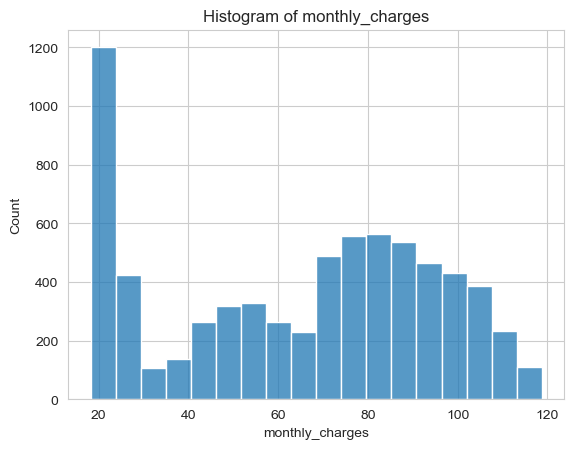

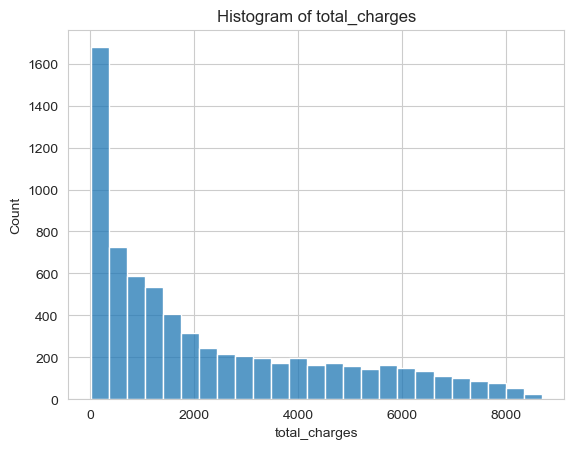

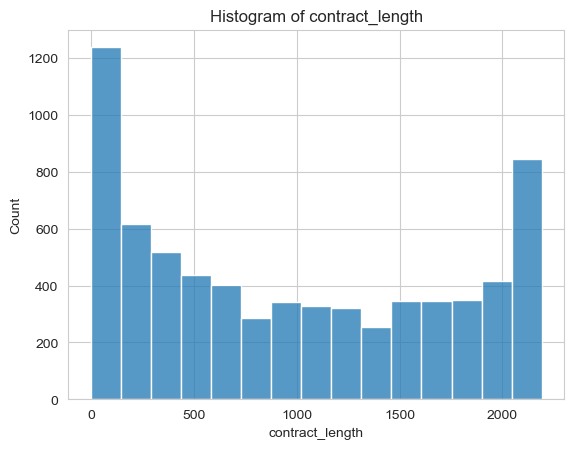

In [66]:
continuous_columns = merged_df[['monthly_charges', 'total_charges', 'contract_length']]

for column in continuous_columns:
    sns.histplot(merged_df, x=column)
    plt.title(f'Histogram of {column}')
    plt.show()

* The distribution of monthly charges has three peaks at $20, $50, and $80 per month.
* Total charges is highly right skewed, with most people paying close to $0 total and only a few people paying over $6000 over the life of their plan.

#### Correlations of Numeric Variables

In [69]:
merged_df[['monthly_charges', 'total_charges', 'contract_length', 'total_internet_services']].corr()

,monthly_charges,total_charges,contract_length,total_internet_services
monthly_charges,1.000000,0.651065,0.247754,0.724706
total_charges,0.651065,1.000000,0.825811,0.746101
contract_length,0.247754,0.825811,1.000000,0.494190
total_internet_services,0.724706,0.746101,0.494190,1.000000


## **Build Models**

### Logistic Regression

### CatBoost

### LightGBM

### XGBoost